点郡データから標高ラスターを生成。パラメータ調整可能。（必要手続き：Driveの接続）

広域の初動の場合、初めて設定したmindepthを実行すると３０分ほどかかります。

ステップ２の再実行後はflag_renewをTrueにしてください。

全て実行した後、maxdepthを変更して外れ値処理以下を１度再実行できるぐらいのリソース有余です。２度目の再実行あたりでRAM不足でクラッシュしますので、RAMが少なそうならば再起動で実行してください。

In [1]:
# @title Googleドライブの準備
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# @title パラメータの設定
casename = "kurume-r2"

mindepth = 0.05 # assume minimal depth of water to be detected
maxdem = 300 # maximum dem assumed for water surface. set something unrealy high.

maxdepth = 4 # m
maxarea = 600000 # in the unit of pixels or 25 m^2

flag_cache = False #True # Set False if you do not want a cache file from the previous time.
flg_display = False

In [3]:
# @title 詳細設定用パラメータ（基本的には操作不要）

enable_savefig = False # True:図をGoogleドライブに保存する

zoomlevel = 15 # DEM zoom level to fetch
wall_height = 1000

analysis_tilesize = 4

errordem = -1000

# デバッグ用出力
global globalflag_debug

# 保存先
path_home = "/content/drive/MyDrive/plateau-2023-uc01-satellite-analytics/PLATEAU-FloodSAR/"
path_dem = path_home + "/DEM/"
path_case = path_home + casename + "/"
file_flbbox = path_case + "floodprb_bbox.npy"
file_pts = path_case + "flood_points.pkl"
file_dem_fmt = path_case + "dem_{}_{}-{}_{}-{}.npz"
file_savepts = path_case + "save_pts.npy"

file_pts_mindepth = path_case + "flood_points_min{0:04d}.pkl"

file_flooddem = path_case + "flood_dem_{0:04d}.npz"
file_flooddepth = path_case + "flood_depth_{0:04d}.npz"

# 標高データの基本パラメータ
demtile_len = 256

In [4]:
# @title 主要ライブラリインポート
!pip install numpy==1.26.0
!pip install scikit-image==0.22.0
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle
import requests
import os
from scipy import ndimage as ndi
from progressbar import progressbar
from shapely import box
import sys
sys.path.append(path_home)
import plateau_floodsar_lib as pfsl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 48.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 68.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.3
    Uninstalling scikit-image-0.19.3:
      Successfully uninstalled scikit-image-0.19.3


In [5]:
# @title 領域の読み込み
boundbox = np.load(file_flbbox)
print(boundbox)

[130.40000697  33.22445068 130.59998291  33.34999988]


## 国土地理院の標高データの取得

In [6]:
# @title DEMマップ取得
print(boundbox)
bbox = box(*boundbox)
print(bbox)
gdm = pfsl.GiajDemManager(path_home,dem_types = [{"type":"dem5a","z":15},{"type":"dem5b","z":15}])
gdm.load_dem_tiles(bbox)
tile = gdm.produce_tile_stiched()
lons = tile["lons"]
lats = tile["lats"]
demmap = tile["dem"]

[130.40000697  33.22445068 130.59998291  33.34999988]
POLYGON ((130.5999829054351 33.224450683790295, 130.5999829054351 33.349999879860974, 130.4000069710961 33.349999879860974, 130.4000069710961 33.224450683790295, 130.5999829054351 33.224450683790295))


100% (19 of 19) |########################| Elapsed Time: 0:01:25 Time:  0:01:25


In [7]:
print("dem range = ", np.nanmin(demmap), np.nanmax(demmap))

dem range =  -0.87 437.88


## 標高に基づいた浸水域の拡大

In [8]:
scale = np.concatenate([np.arange(3,10,1),np.arange(10,maxdem+30,30)])
print(scale)

[  3   4   5   6   7   8   9  10  40  70 100 130 160 190 220 250 280 310]


In [9]:
vbi = pfsl.ValueBoundInspector(gdm, scale=scale)#, method=lambda data,x:data>=x)
vbi.set_cntrs_all()


  0% (0 of 18) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Preparing all contours


100% (18 of 18) |########################| Elapsed Time: 0:00:05 Time:  0:00:05


In [10]:
#@title 点郡の読み込み＆DEM情報付与
pts_filepath = file_pts_mindepth.format(int(mindepth*100))
if flag_cache and os.path.isfile(pts_filepath):
  print(f"Loading the previous result from {pts_filepath}")
  with open(file_pts, "rb") as ifile:
    flood_pts = pickle.load(ifile)
else:
  with open(file_pts, "rb") as ifile:
    flood_pts = pickle.load(ifile)
  for pt in progressbar(flood_pts):
    if "dem" not in pt:
      try:
        pt["dem"] = gdm.calc_dem_interp(pt["lon"],pt["lat"])+mindepth
      except IndexError:
        pt["dem"] = np.nan
  flood_pts = [pt for pt in flood_pts if pt["dem"] <= maxdem]
  for pt in progressbar(flood_pts):
    if "area" not in pt:
      pt["area"] = vbi.calc_area_bound(pt["lon"],pt["lat"],pt["dem"])
    if "mindem" not in pt:
      pt["mindem"] = vbi.get_mindem_bound(pt["lon"],pt["lat"],pt["dem"])
    if "maxdepth" not in pt:
      pt["maxdepth"] = pt["dem"] - pt["mindem"]
  vbi.release_cntrs_all()
  with open(pts_filepath, "wb") as ofile:
    pickle.dump(flood_pts, ofile)
  print(f"The points are saved to {pts_filepath} for future runs.")
print(len(flood_pts))
print(flood_pts[0:3])
print(demmap.shape)
print(lats.shape)
print(lons.shape)

100% (1745177 of 1745177) |##############| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (0 of 1076016) |                    | Elapsed Time: 0:00:00 ETA:  --:--:--/content/drive/MyDrive/plateau-2023-uc01-satellite-analytics/PLATEAU-FloodSAR/plateau_floodsar_lib.py:674: RuntimeWarning: All-NaN axis encountered
  return np.nanmin([mdl,mdh])
100% (1076016 of 1076016) |##############| Elapsed Time: 0:05:00 Time:  0:05:00


The points are saved to /content/drive/MyDrive/plateau-2023-uc01-satellite-analytics/PLATEAU-FloodSAR/kurume-r2/flood_points_min0005.pkl for future runs.
1076016
[{'lon': 130.40014877021386, 'lat': 33.27198702770918, 'dem': 3.4197527460055333, 'area': nan, 'mindem': nan, 'maxdepth': nan}, {'lon': 130.40010564510843, 'lat': 33.27198440967996, 'dem': 3.4414160385378163, 'area': nan, 'mindem': nan, 'maxdepth': nan}, {'lon': 130.40015268908334, 'lat': 33.271965859927285, 'dem': 3.3489110524716166, 'area': nan, 'mindem': nan, 'maxdepth': nan}]
(3840, 4864)
(3840,)
(4864,)


In [11]:
gdm = 0

In [12]:
del gdm

In [13]:
vbi.release_cntrs_all()  # 事前計算領域の削除、メモリー領域の開放

### 外れ値処理

In [14]:
print(flood_pts[0])

{'lon': 130.40014877021386, 'lat': 33.27198702770918, 'dem': 3.4197527460055333, 'area': nan, 'mindem': nan, 'maxdepth': nan}


(0.0, 10.0)

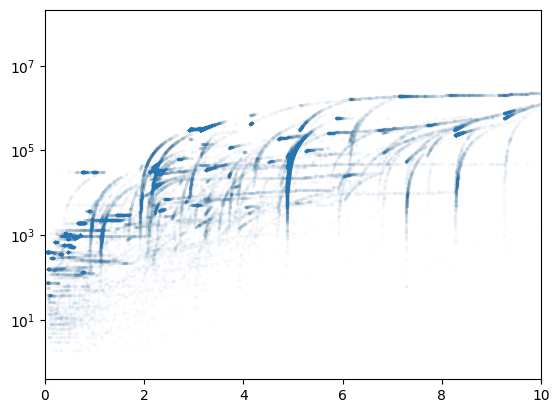

In [15]:
xx = [ee["maxdepth"] for ee in flood_pts]
yy = [ee["area"] for ee in flood_pts]
ax =plt.subplot(1,1,1)
ax.scatter(xx,yy, s=3, alpha=0.01)
plt.yscale('log')
ax.set_xlim(0, 10)

In [16]:
selected_pts = [pt for pt in flood_pts if pt["maxdepth"] < maxdepth and pt["area"]<=maxarea]
print(f"{len(selected_pts)} / {len(flood_pts)}")

37795 / 1076016


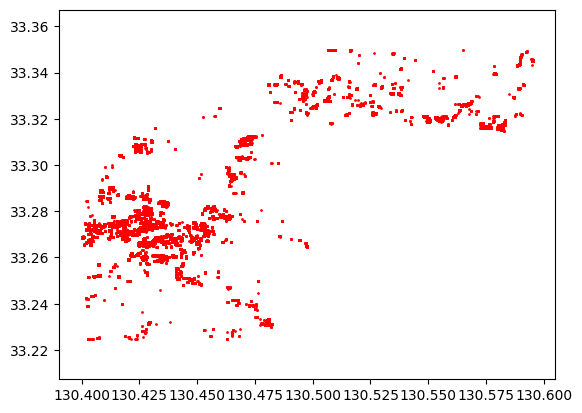

In [17]:
if True: # flg_display:
  xx = [pt["lon"] for pt in selected_pts]
  yy = [pt["lat"] for pt in selected_pts]
  ax = plt.subplot(111)
  ax.scatter(xx,yy,s=1,c="r")
  ax.axis("equal")

In [18]:
sorted_pts = sorted(selected_pts, key=lambda x:x["dem"], reverse=True)

In [19]:

floodmap_msk = np.zeros_like(vbi.data, dtype=float)
floodmap_dem = np.ones_like(vbi.data) * errordem
save_pts = []
cnt0 = 10000
cnt = cnt0
for pt in progressbar(sorted_pts):
  cx, cy = vbi.calc_floatIdxs(pt["lon"],pt["lat"])
  cx = int(cx)
  cy = int(cy)
  if pt["area"] > 0 and floodmap_msk[cy,cx] == 0: #and floodmap_dem[cy,cx] < pt["dem"]:
    tmp_msk = vbi.generate_boundmap_exact(pt["lon"],pt["lat"], pt["dem"])
    tmp_dem = tmp_msk * pt["dem"] + (1-tmp_msk) * errordem
    cnt = cnt  - 1
    tmp_id = tmp_msk * cnt
    floodmap_msk = np.maximum(floodmap_msk, tmp_id)
    floodmap_dem = np.maximum(floodmap_dem, tmp_dem)
    save_pts.append(pt)
floodmap_dem = floodmap_dem[1:-1,1:-1]
floodmap_dem[np.where(floodmap_dem == errordem)] = np.nan
floodmap_msk = floodmap_msk[1:-1,1:-1]
floodmap_msk[np.where(floodmap_msk)==0] = np.nan
floodmap_msk = cnt0 - floodmap_msk
cnt = cnt0-cnt

100% (37795 of 37795) |##################| Elapsed Time: 0:01:33 Time:  0:01:33


In [20]:
print(cnt)
print(np.nanmin(floodmap_msk),np.nanmax(floodmap_msk))
print(floodmap_msk)
print(floodmap_dem)

183
1.0 10000.0
[[178. 178. 178. ... 178. 178. 178.]
 [178. 178. 178. ... 178. 178. 178.]
 [178. 178. 178. ... 178. 178. 178.]
 ...
 [178. 178. 178. ... 178. 178. 178.]
 [178. 178. 178. ... 178. 178. 178.]
 [178. 178. 178. ... 178. 178. 178.]]
[[2.87414751 2.87414751 2.87414751 ... 2.87414751 2.87414751 2.87414751]
 [2.87414751 2.87414751 2.87414751 ... 2.87414751 2.87414751 2.87414751]
 [2.87414751 2.87414751 2.87414751 ... 2.87414751 2.87414751 2.87414751]
 ...
 [2.87414751 2.87414751 2.87414751 ... 2.87414751 2.87414751 2.87414751]
 [2.87414751 2.87414751 2.87414751 ... 2.87414751 2.87414751 2.87414751]
 [2.87414751 2.87414751 2.87414751 ... 2.87414751 2.87414751 2.87414751]]


In [21]:
demmap = vbi.data[1:-1,1:-1]
depthmap = floodmap_dem - demmap
depthmap[np.where(depthmap < 0)] = np.nan
floodmap_dem[np.where(np.isnan(depthmap))] = np.nan
floodmap_msk[np.where(np.isnan(depthmap))] = np.nan

In [22]:
print(depthmap)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [23]:
print(floodmap_msk)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


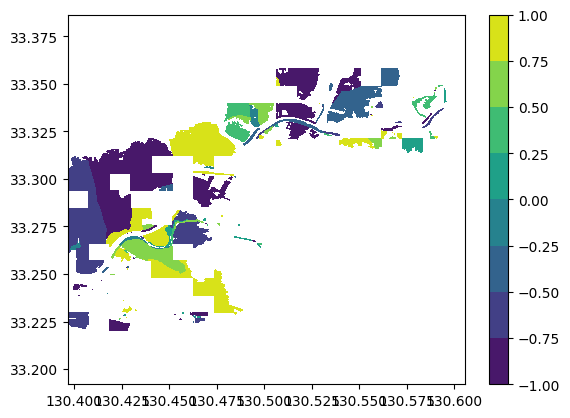

In [24]:
if True: #flg_display:
  ax =plt.subplot(1,1,1)
  img = ax.contourf(lons,lats, np.sin(floodmap_msk*0.1))#,levels=np.arange(1,cnt+10,10))
  ax.axis("equal")
  plt.colorbar(img)

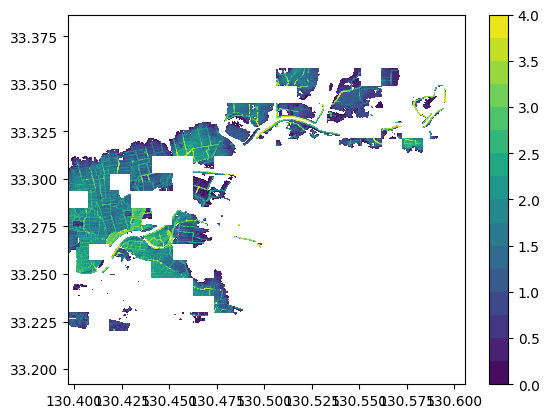

In [25]:
if True: #flg_display:
  ax =plt.subplot(1,1,1)
  img = ax.contourf(lons,lats, depthmap,levels=np.arange(0,maxdepth+0.1,0.25))
  ax.axis("equal")
  plt.colorbar(img)

In [26]:
if flg_display:
  xx = [pt["lon"] for pt in sorted_pts]
  yy = [pt["lat"] for pt in sorted_pts]
  ax =plt.subplot(1,1,1)
  img = ax.contourf(lons,lats, depthmap,levels=np.arange(0,maxdepth+0.1,0.25))
  plt.colorbar(img)
  ax.scatter(xx,yy, c="c", s=0.1)
  ax.axis("equal")
  ax.set_xlim(130.4,130.5)
  ax.set_ylim(33.22,33.32)

In [27]:
del img

In [28]:
print(floodmap_dem)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [29]:
print(len(save_pts))

183


In [30]:
np.savez(file_flooddem.format(int(maxdepth*100)), lons=lons, lats=lats, floodmap_dem=floodmap_dem)
np.savez(file_flooddepth.format(int(maxdepth*100)), lons=lons, lats=lats, floodmap_depth=depthmap)